In [4]:
pip install tifffile

     |████████████████████████████████| 220 kB 1.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install csbdeep

     |████████████████████████████████| 71 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 10.2 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install stardist

     |████████████████████████████████| 3.1 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 313 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 3.0 MB/s eta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

     |████████████████████████████████| 479.6 MB 51 kB/s  eta 0:00:012
     |████████████████████████████████| 1.7 MB 458 kB/s eta 0:00:01
     |████████████████████████████████| 440 kB 2.6 MB/s eta 0:00:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
     |████████████████████████████████| 5.3 MB 2.9 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl (24.5 MB)
     |████████████████████████████████| 5.6 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 2.2 MB/s eta 0:00:01
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     |████████████████████████

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20
def plot_img_label(img, lbl, cls_dict, n_classes=2, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    class_img[...,:3][res==0] = 0 
    class_img[...,-1][res==0] = 1
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

In [3]:
# set the number of object classes
n_classes = 6

In [25]:
img_arr = np.load('/home/ravi/Mohit/stardist_original/archive/data/images.npy')
ann_arr = np.load('/home/ravi/Mohit/stardist_original/archive/data/labels.npy')

seg_arr = ann_arr[:,:,:,0]
class_arr = ann_arr[:,:,:,1]

print(img_arr.shape)
print(seg_arr.shape)
print(class_arr.shape)

(4981, 256, 256, 3)
(4981, 256, 256)
(4981, 256, 256)


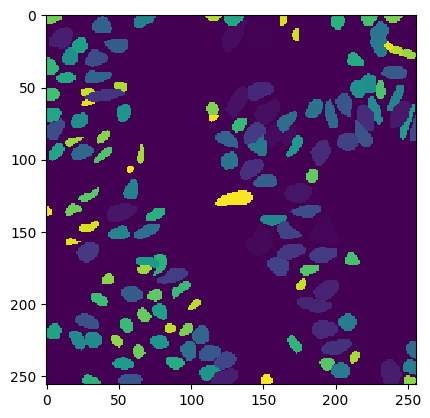

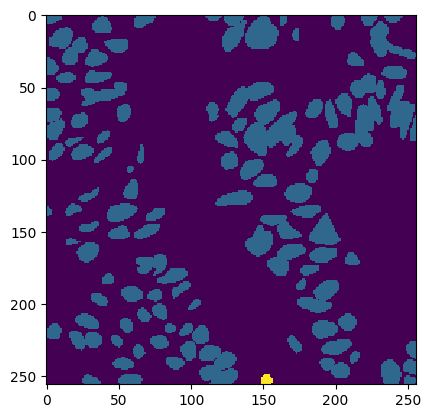

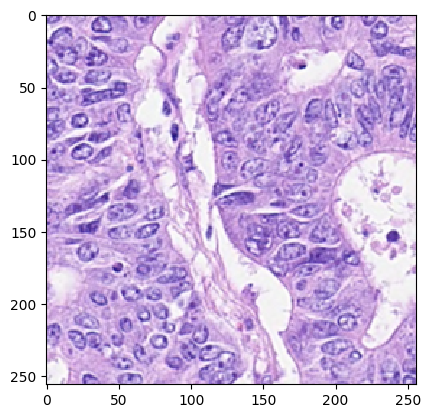

In [26]:
plt.imshow(seg_arr[0], interpolation='nearest')
plt.show()
plt.imshow(class_arr[0], interpolation='nearest')
plt.show()
plt.imshow(img_arr[0], interpolation='nearest')
plt.show()

In [27]:
def get_sample_prob(cls_dict):

    neu_count = 0
    eos_count = 0

    for key in cls_dict:

        val = cls_dict[key]
        
        if val == 1:
            neu_count += 1

        if val == 5:
            eos_count += 1

    tot_minor = neu_count + eos_count

    return tot_minor

In [28]:
# Create class dictionary

tuple_list = []
prob_list = []
idx_list = []

for i in tqdm(range(len(img_arr))):

    cls_dict = {}
    cur_img = img_arr[i]
    cur_seg = seg_arr[i]
    cur_class = class_arr[i]

    comb_arr = cur_seg + 1000*cur_class
    unique_comb = np.unique(comb_arr)

    for val in unique_comb:
        
        rem = val%1000
        val = val - rem
        quo = int(val/1000)
        cls_dict[rem] = quo

    prob = get_sample_prob(cls_dict)

    if(prob >= 5):
        prob_list.append(prob)
        idx_list.append(i)

    tuple_list.append((cur_img, cur_seg, cls_dict))

tot = sum(prob_list)
norm = [float(i)/tot for i in prob_list]        

100%|█████████████████████████████████████| 4981/4981 [00:04<00:00, 1083.40it/s]


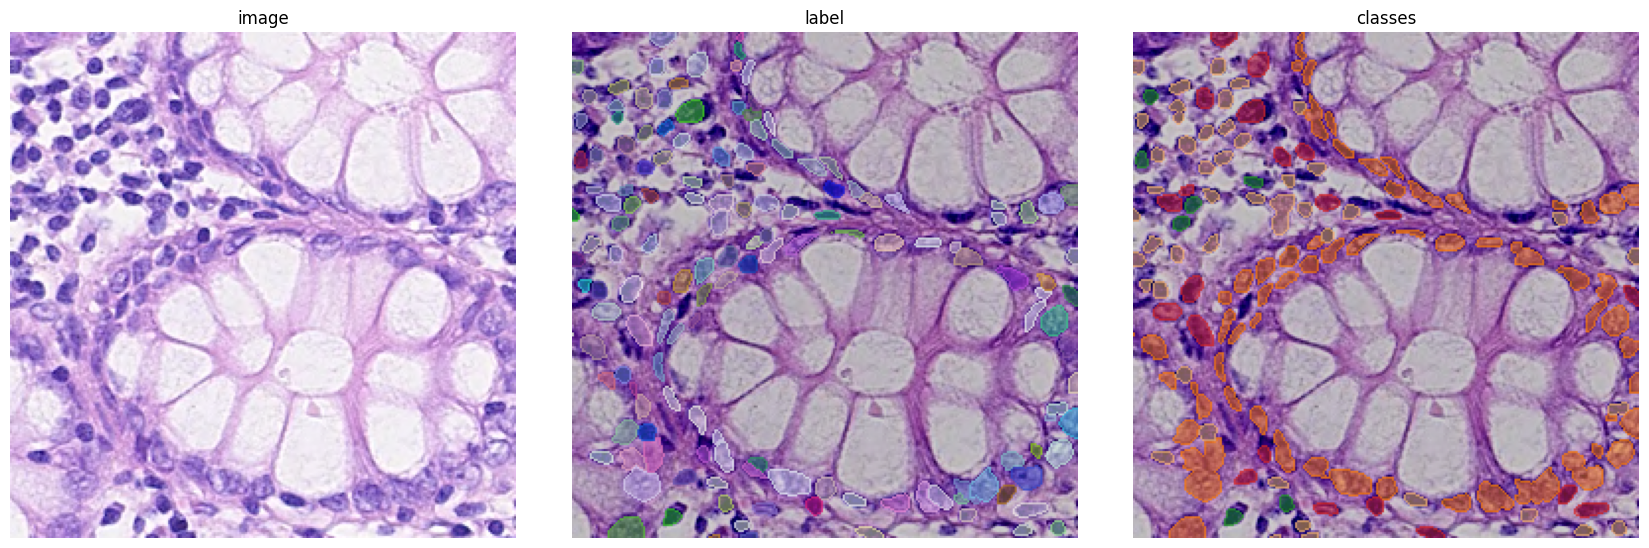

In [29]:
ex_img, ex_seg, ex_cls = tuple_list[10]

ax = plot_img_label(ex_img,ex_seg,ex_cls, n_classes=n_classes)
for a in ax: a.axis("off")

In [30]:
# Adding 1500 extra samples based on oversampling
import random

extra_idx = random.choices(population=idx_list, weights=norm, k=1500)

for idx in extra_idx:

    tup = tuple_list[idx]
    tuple_list.append(tup)

print(len(tuple_list))

6481


In [31]:
X, Y, C = tuple(zip(*tuple(tuple_list)))

assert len(X) == len(Y) == len(C)

In [32]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [33]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████████████████████████████████| 6481/6481 [00:42<00:00, 151.95it/s]


In [34]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [C[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train],  [C[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 6481
- training:       5509
- validation:     972


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Axes: title={'center': 'image'}>,
 <Axes: title={'center': 'label'}>,
 <Axes: title={'center': 'classes'}>)

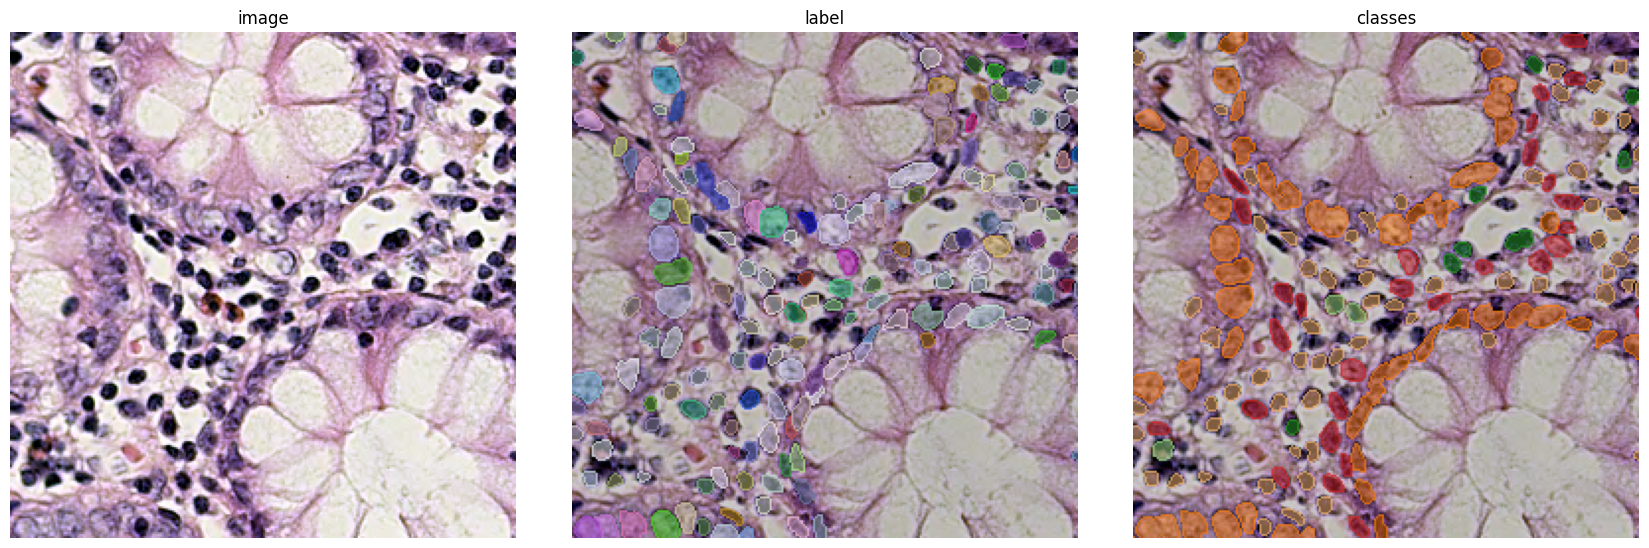

In [35]:
i = min(8, len(X)-1)
img, lbl, cls = X[i], Y[i], C[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img, lbl, cls, n_classes)

In [36]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [37]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = n_classes,   # set the number of object classes
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_classes=6, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1, 1, 1, 1, 1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2, 1), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), u

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 6,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1, 1, 1, 1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_

In [38]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)
    # alternatively, adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)

In [41]:
model = StarDist2D(conf, name='stardist_multiclass', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [42]:
model = StarDist2D(None, name='stardist_multiclass', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [43]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2024-07-04 14:20:27.060512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:425] Loaded runtime CuDNN library: 8.0.4 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-07-04 14:20:27.062060: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'model_4/conv2d_8/Relu' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_163278/2119120405.py", line 2, in <module>
      fov = np.array(model._axes_tile_overlap('YX'))
    File "/home/ravi/.local/lib/python3.8/site-packages/stardist/models/base.py", line 1105, in _axes_tile_overlap
      self._tile_overlap = self._compute_receptive_field()
    File "/home/ravi/.local/lib/python3.8/site-packages/stardist/models/base.py", line 1084, in _compute_receptive_field
      y  = keras_model.predict(x, verbose=0)[0][0,...,0]
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'model_4/conv2d_8/Relu'
DNN library is not found.
	 [[{{node model_4/conv2d_8/Relu}}]] [Op:__inference_predict_function_9061]

In [21]:

def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    #random flops and rotations
    x, y = random_fliprot(x, y)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


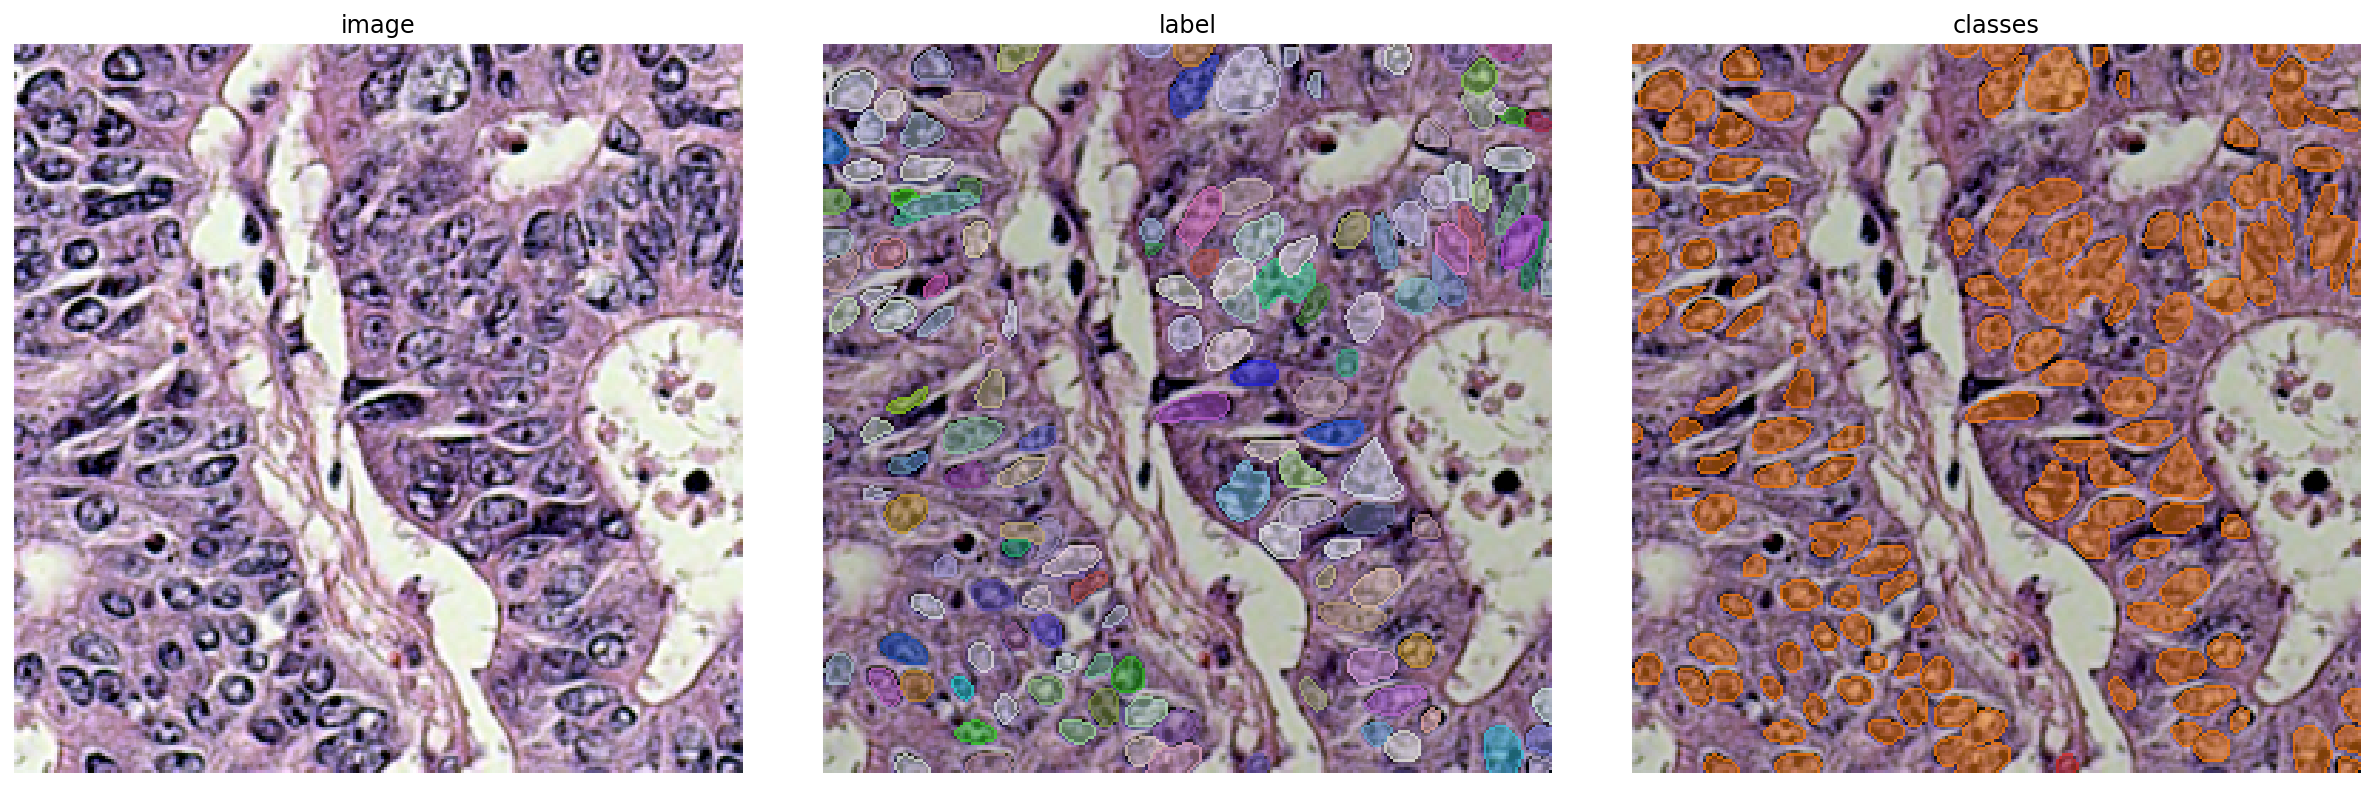

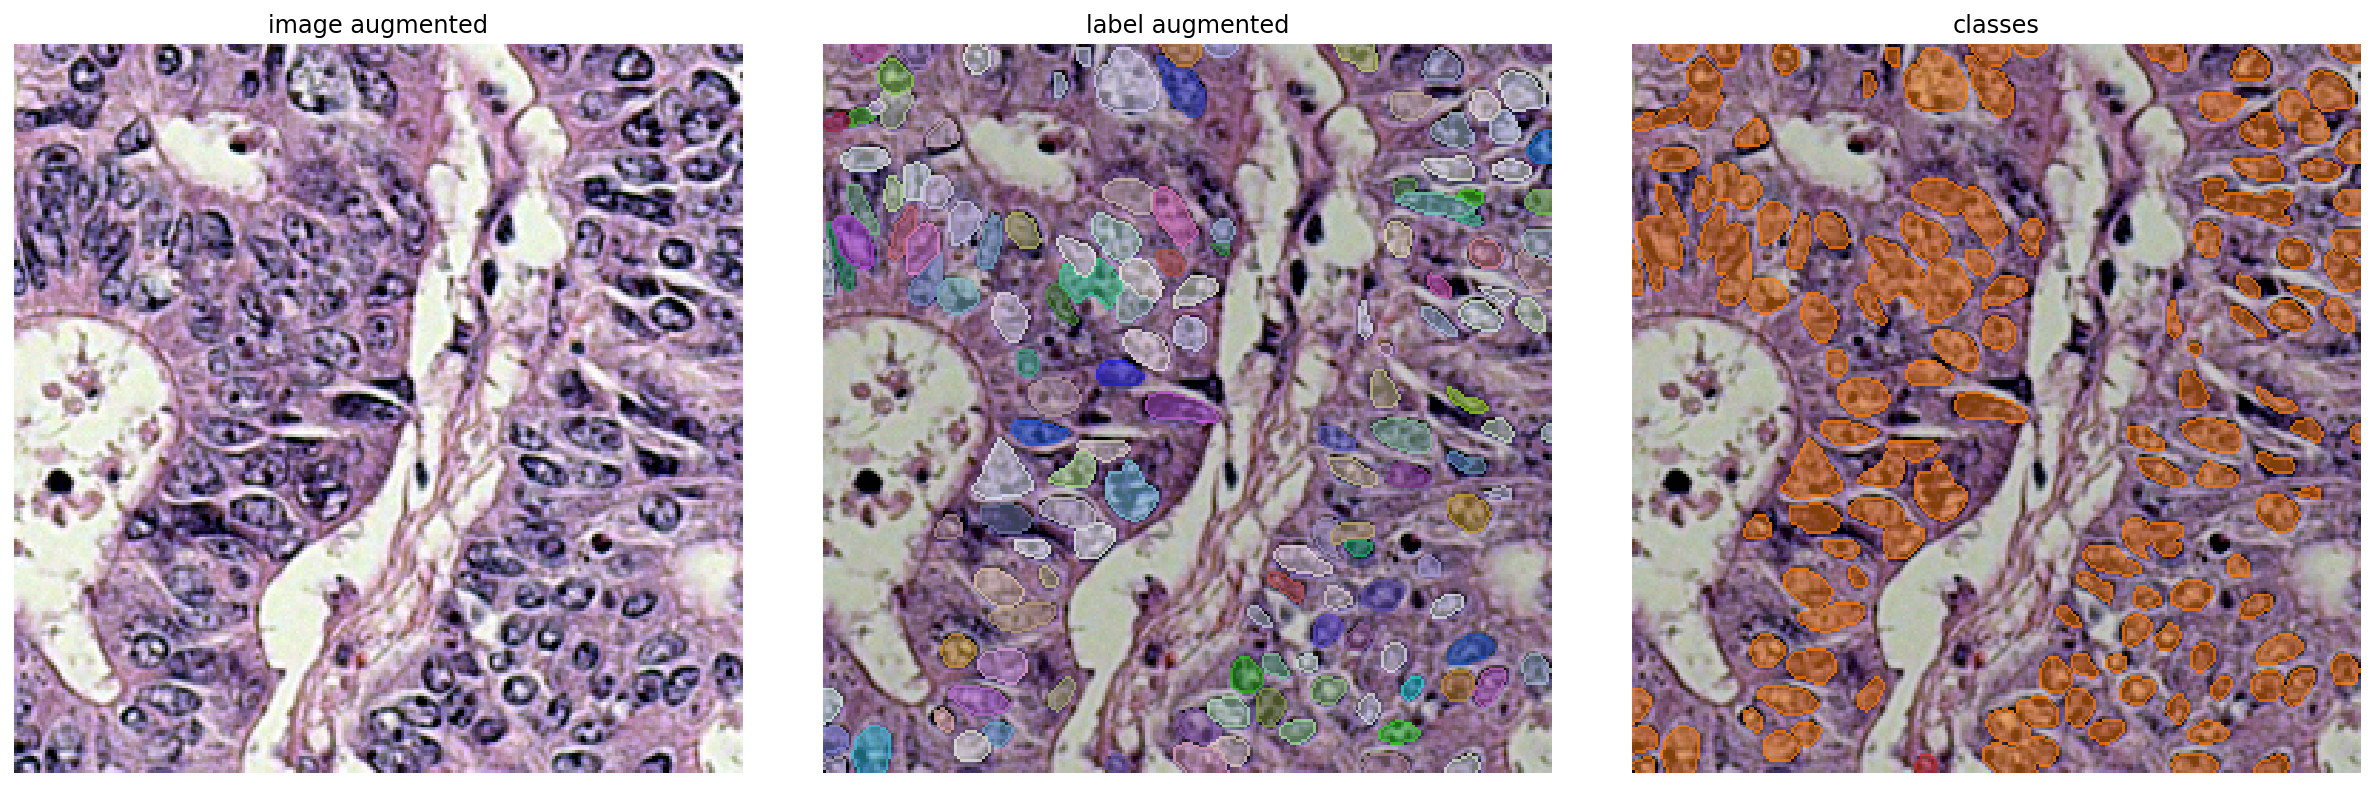

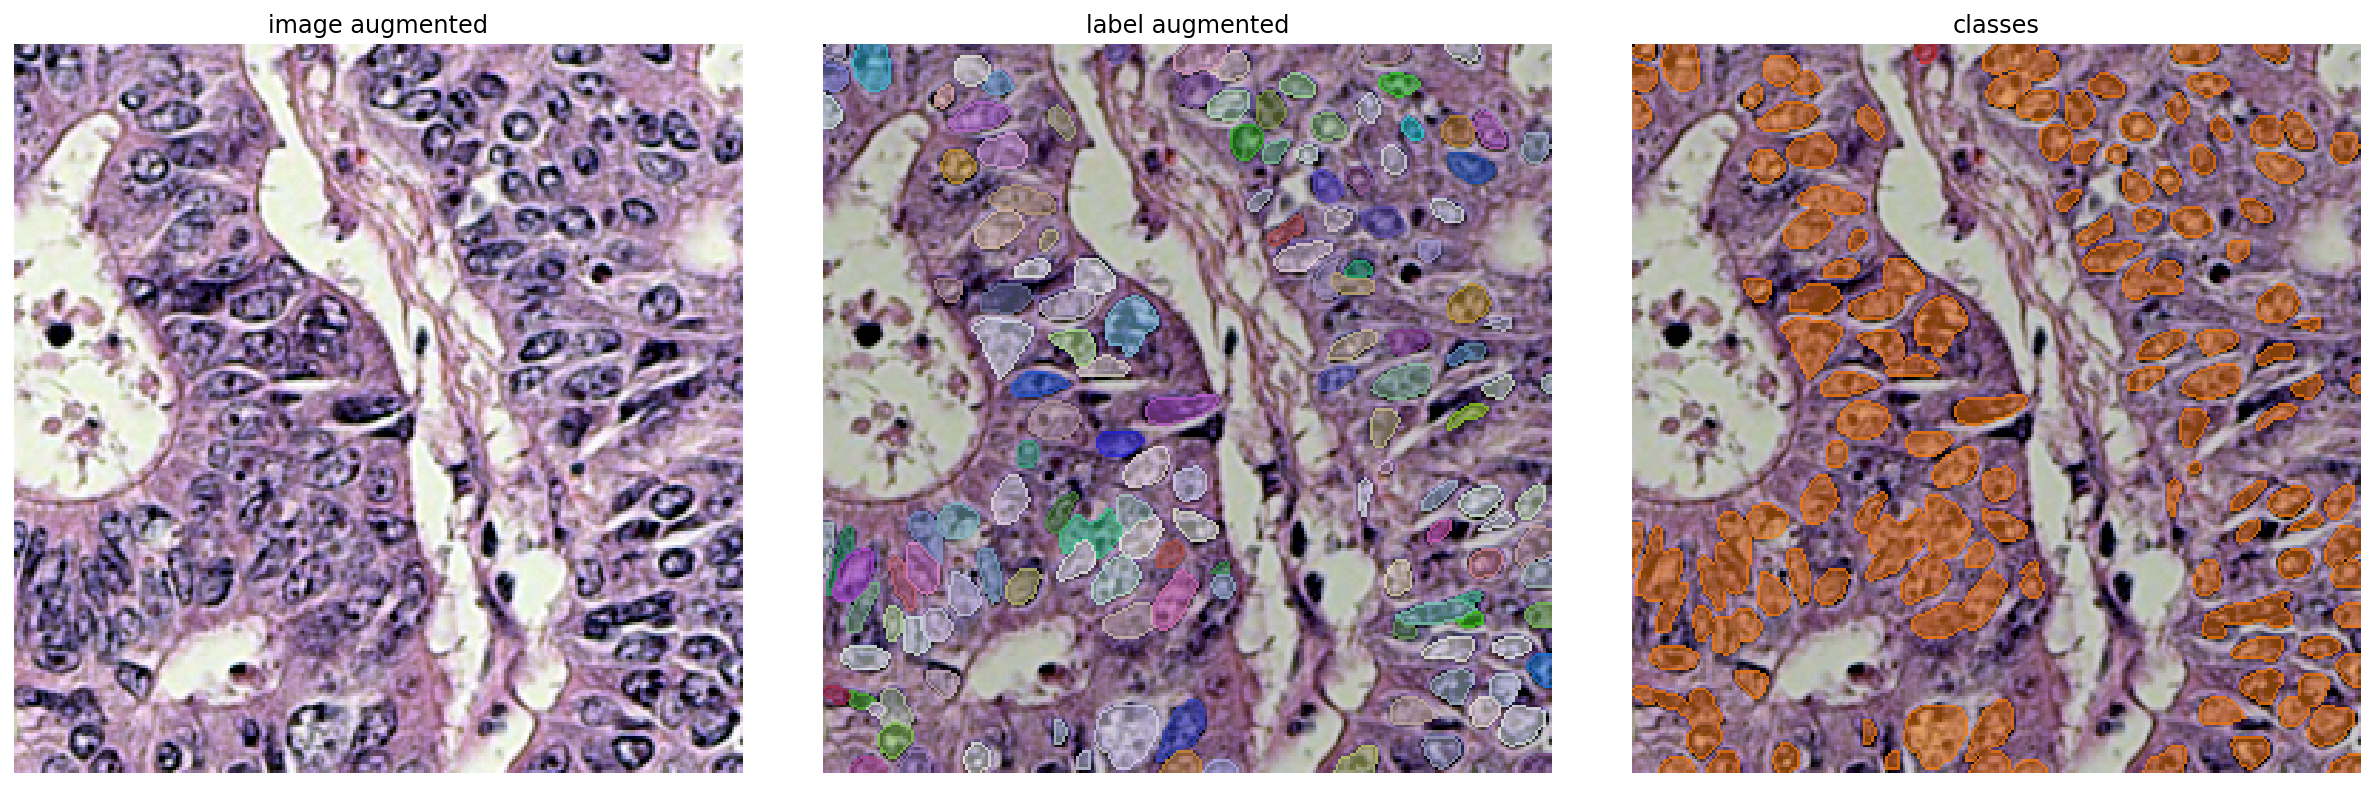

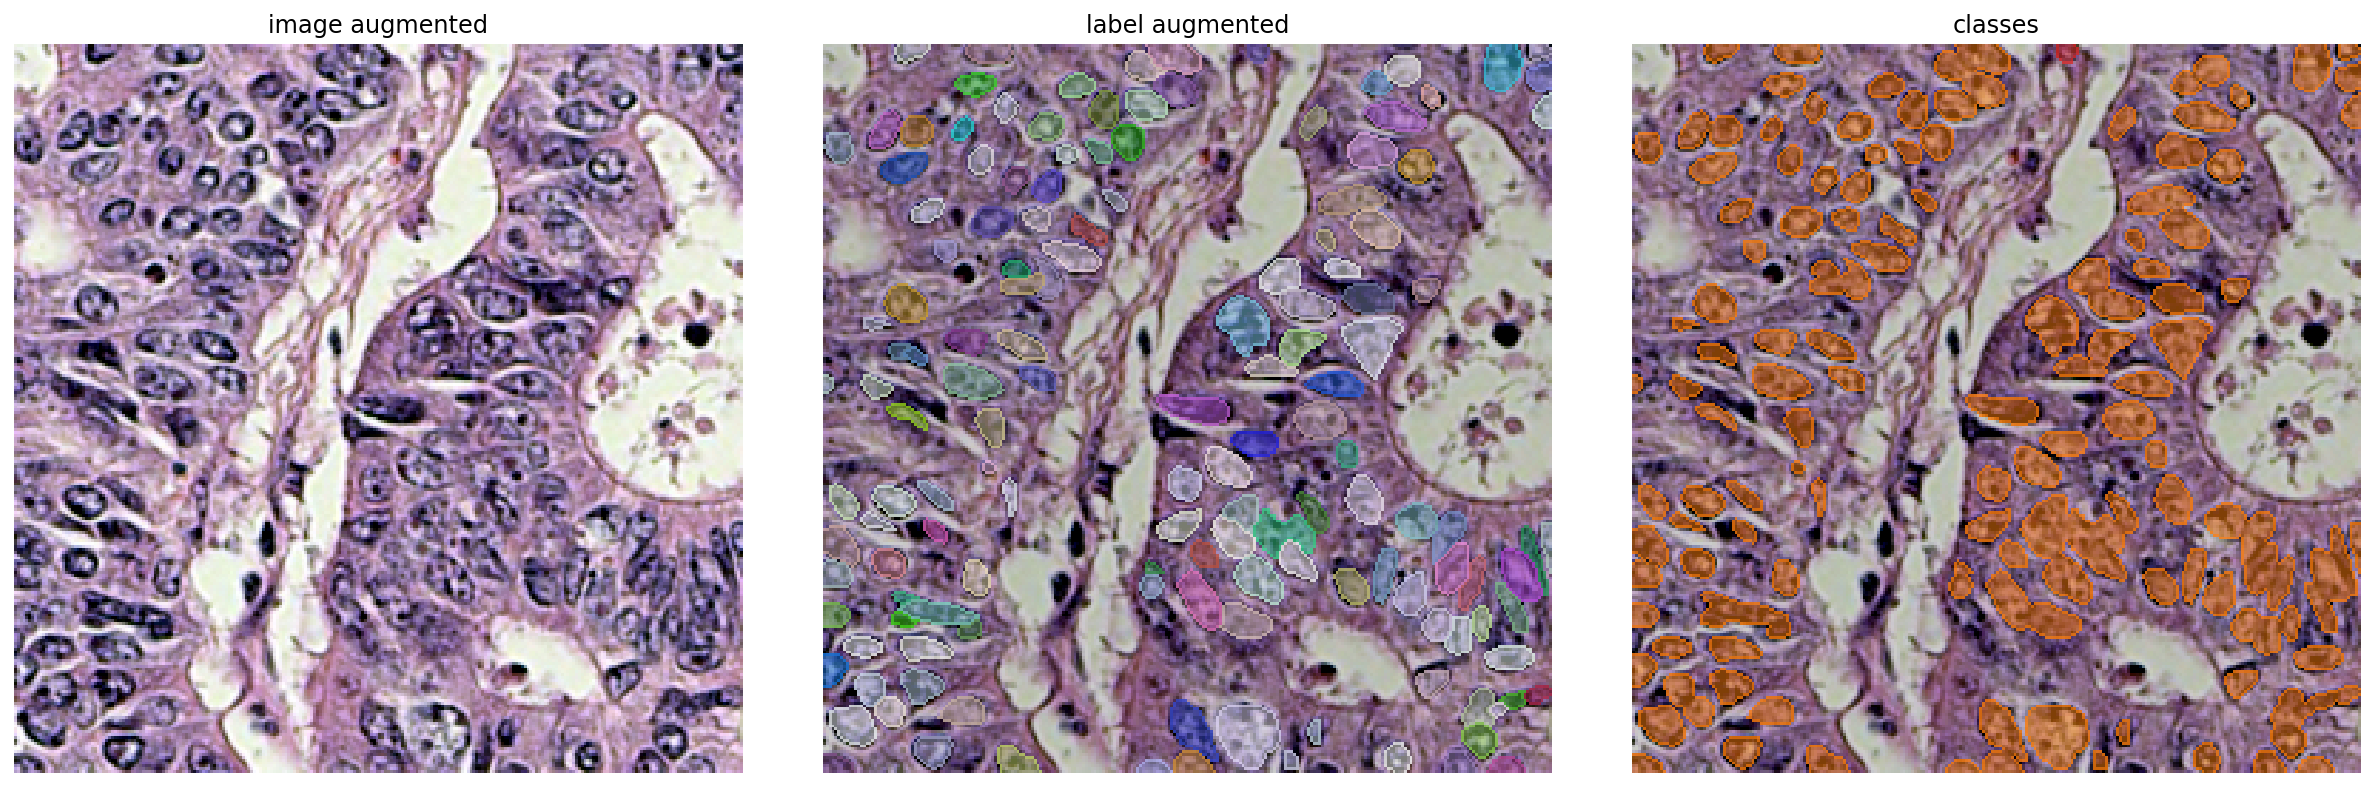

In [27]:
# plot some augmented examples
img, lbl, cls = X[0], Y[0], C[0]
plot_img_label(img,lbl,cls, n_classes=n_classes)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug,lbl_aug,cls, img_title="image augmented", lbl_title="label augmented", n_classes=n_classes)

In [22]:
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
            epochs=5)

Epoch 1/5


2024-07-03 15:43:13.799464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:425] Loaded runtime CuDNN library: 8.0.4 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-07-03 15:43:13.800665: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.
2024-07-03 15:43:13.800699: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 1190615008876988806
2024-07-03 15:43:13.800710: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 3134146854200436040
2024-07-03 15:43:13.800720: I tensorflow/core/framework/local_rendezvous.cc:409] Local rend

UnimplementedError: Graph execution error:

Detected at node 'model_1/conv2d_2/Relu' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_163278/2961395484.py", line 1, in <module>
      model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
    File "/home/ravi/.local/lib/python3.8/site-packages/stardist/models/model2d.py", line 475, in train
      history = fit(iter(self.data_train), validation_data=data_val,
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/home/ravi/.local/lib/python3.8/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_2/Relu'
DNN library is not found.
	 [[{{node model_1/conv2d_2/Relu}}]] [Op:__inference_train_function_6922]

In [168]:
model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 34ms/step


NMS threshold = 0.5:  80%|████████████████████████████████████▊         | 16/20 [01:55<00:28,  7.24s/it, 0.475 -> 0.311]


Using optimized values: prob_thresh=0.465953, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.46595299083026837, 'nms': 0.3}

In [169]:
i = 500
label, res = model.predict_instances(X_val[i], n_tiles=model._guess_n_tiles(X_val[i]))

1/1 [==============================] - 0s 36ms/step


In [170]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 

def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict

print(class_from_res(res))

{1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 2, 8: 3, 9: 3, 10: 3, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3, 24: 3, 25: 3, 26: 3, 27: 3, 28: 3, 29: 2, 30: 3, 31: 3, 32: 3, 33: 3, 34: 2, 35: 3, 36: 3, 37: 3, 38: 3, 39: 2, 40: 2, 41: 2, 42: 3, 43: 2, 44: 2, 45: 3, 46: 3, 47: 2, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 2, 54: 3, 55: 3, 56: 2, 57: 3, 58: 3, 59: 2, 60: 2, 61: 6, 62: 3, 63: 2, 64: 2, 65: 3, 66: 2, 67: 3, 68: 2, 69: 3, 70: 3, 71: 6, 72: 6, 73: 3, 74: 2, 75: 6, 76: 6, 77: 3, 78: 6, 79: 6, 80: 2, 81: 2, 82: 2, 83: 2, 84: 2, 85: 2, 86: 2, 87: 2, 88: 3, 89: 2, 90: 2, 91: 2, 92: 3, 93: 2, 94: 2, 95: 2, 96: 2, 97: 2, 98: 2, 99: 2, 100: 2, 101: 2, 102: 2, 103: 0, 104: 2, 105: 2, 106: 3, 107: 2, 108: 6, 109: 6, 110: 2, 111: 2, 112: 2, 113: 6, 114: 6, 115: 6, 116: 2, 117: 6, 118: 6, 119: 2, 120: 2, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 2, 127: 2, 128: 2, 129: 2, 130: 2, 131: 6, 132: 2, 133: 2, 134: 2, 135: 2, 136: 2, 137: 2, 138: 2, 139

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'image'}>,
 <AxesSubplot:title={'center':'Pred'}>,
 <AxesSubplot:title={'center':'classes'}>)

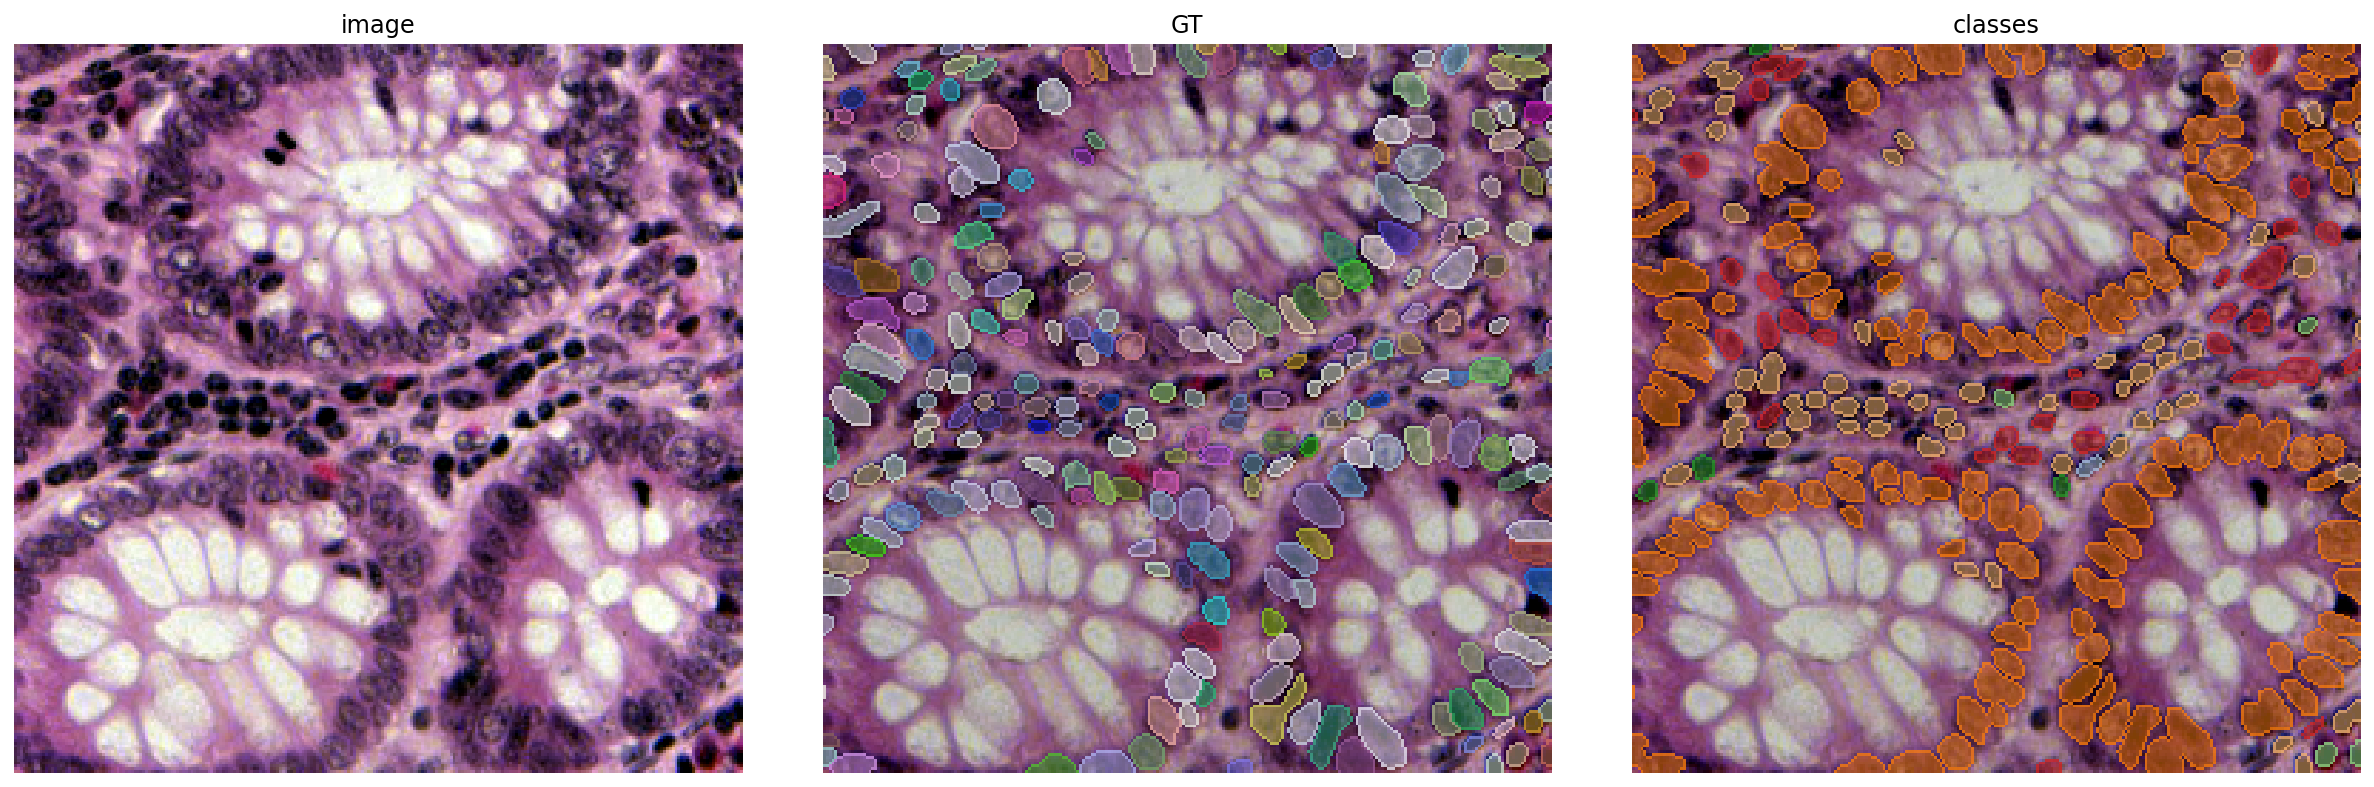

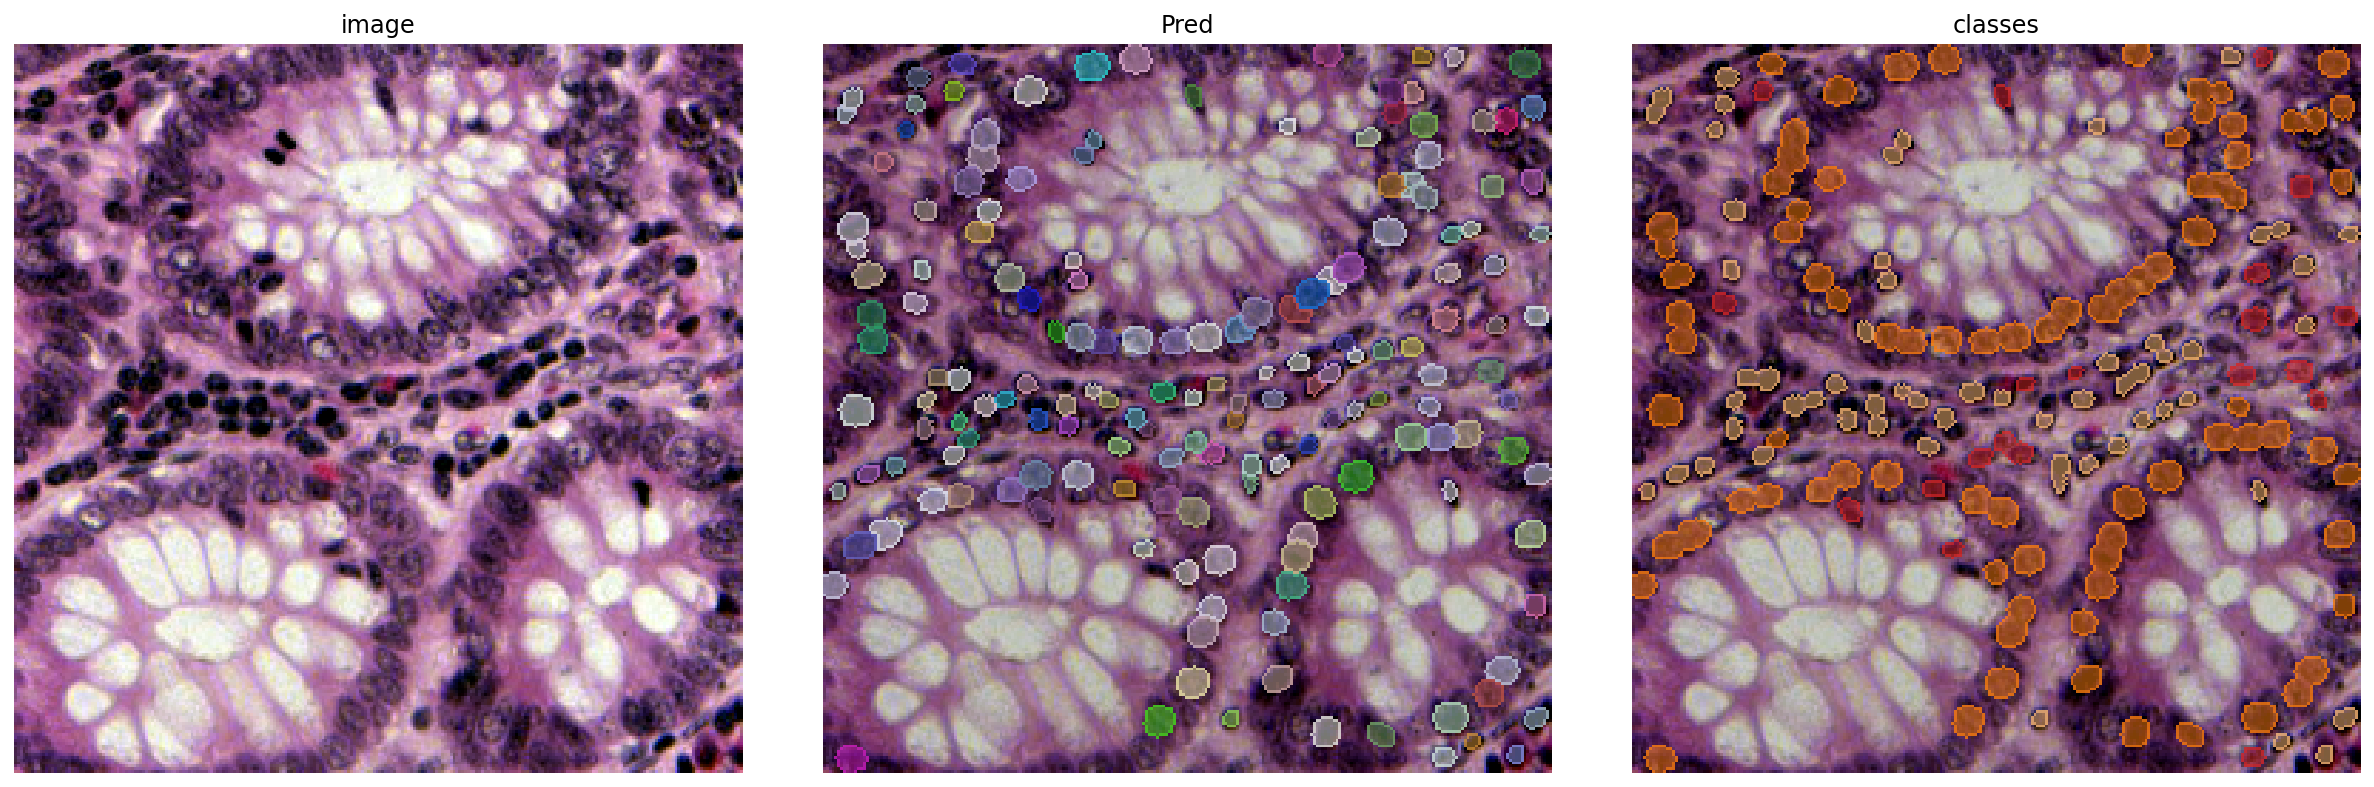

In [171]:
plot_img_label(X_val[i], Y_val[i], C_val[i], n_classes=n_classes, lbl_title="GT")
plot_img_label(X_val[i], label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")

1/1 [==============================] - 0s 21ms/step


848280450.py (9): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'image'}>,
 <AxesSubplot:title={'center':'Pred'}>,
 <AxesSubplot:title={'center':'classes'}>)

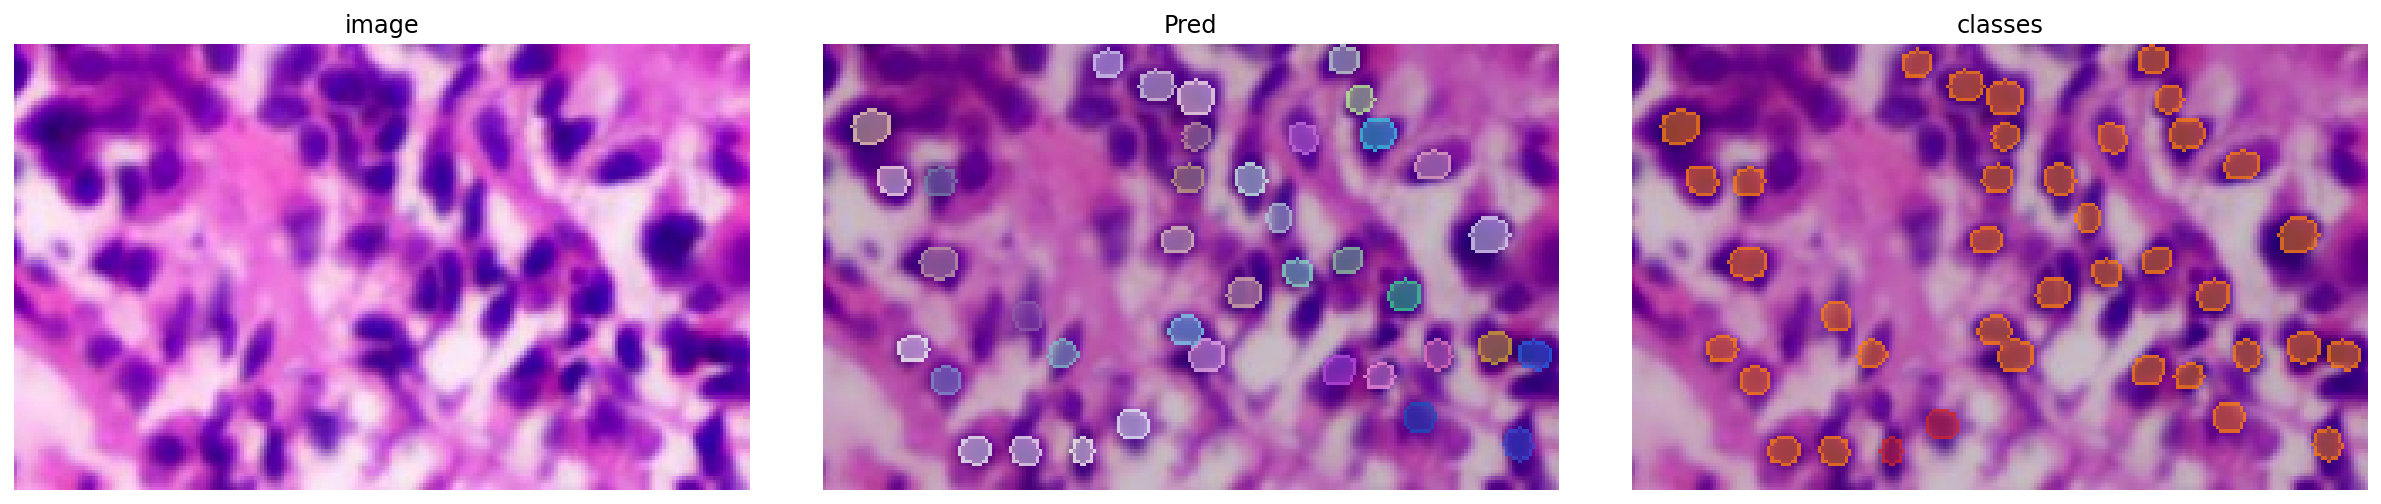

In [178]:
# Testing on custom
from imageio import imread

def abspath(path):
    import os
    base_path = os.path.abspath(os.path.dirname(__file__))
    return os.path.join(base_path, path)

img = imread("test2.jpg")
img = normalize(img)
# img = X_val[500]

label, res = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
plot_img_label(img, label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")

In [ ]:
#ing on custom
from imageio import imread

def abspath(path):
    import os
    base_path = os.path.abspath(os.path.dirname(__file__))
    return os.path.join(base_path, path)

from PIL import Image
img = Image.open("0005.jpg")
wpercent = (750/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((750,hsize), Image.ANTIALIAS)
img.save('00055.jpg')

img = imread("00055.jpg")

img = normalize(img)
# img = X_val[500]

label, res = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
plot_img_label(img, label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")#

In [ ]:
# Testing on custom
from imageio import imread

def abspath(path):
    import os
    base_path = os.path.abspath(os.path.dirname(__file__))
    return os.path.join(base_path, path)

from PIL import Image
img = Image.open("test3.jpg")
wpercent = (750/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((750,hsize), Image.ANTIALIAS)
img.save('test33.jpg')

img = imread("test33.jpg")

img = normalize(img)
# img = X_val[500]

label, res = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
plot_img_label(img, label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")

In [ ]:
# Testing on custom
from imageio import imread

def abspath(path):
    import os
    base_path = os.path.abspath(os.path.dirname(__file__))
    return os.path.join(base_path, path)

from PIL import Image
img = Image.open("0004.jpg")
wpercent = (750/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((750,hsize), Image.ANTIALIAS)
img.save('00044.jpg')

img = imread("00044.jpg")

img = normalize(img)
# img = X_val[500]

label, res = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
plot_img_label(img, label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")

In [ ]:
# Testing on custom
from imageio import imread

def abspath(path):
    import os
    base_path = os.path.abspath(os.path.dirname(__file__))
    return os.path.join(base_path, path)

from PIL import Image
img = Image.open("a.jpg")
wpercent = (750/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((750,hsize), Image.ANTIALIAS)
img.save('aa.jpg')

img = imread("aa.jpg")

img = normalize(img)
# img = X_val[500]

label, res = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
plot_img_label(img, label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")

In [ ]:
# Testing on custom
from imageio import imread

def abspath(path):
    import os
    base_path = os.path.abspath(os.path.dirname(__file__))
    return os.path.join(base_path, path)

from PIL import Image
img = Image.open("b.jpg")
wpercent = (750/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((750,hsize), Image.ANTIALIAS)
img.save('bb.jpg')

img = imread("bb.jpg")

img = normalize(img)
# img = X_val[500]

img_ann=imread("a_ann.jpg")
img_ann = normalize(img_ann)

label, res = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
plot_img_label(img, label, class_from_res(res), n_classes=n_classes, lbl_title="Pred")
